# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import skopt
from skopt import BayesSearchCV

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,  GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, recall_score

import lightgbm as lgb
import xgboost as xgb



# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
azdias = pd.read_csv('azdias.csv', sep=',')

c:\users\lanth\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
customers = pd.read_csv('customers.csv', sep=',')

In [6]:
print(azdias.iloc[:,19:21].columns)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


### So we see that the problem comes from 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015' columns,
### we will investigate a little more.

In [7]:
azdias.CAMEO_DEUG_2015.unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [8]:
azdias.CAMEO_INTL_2015.unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

### We can see that there are ints , floats and strings 
### We could convert everthing to float after we replace the 'X' and 'XX' with np.nan

In [2]:
def cameo_fix(df):
    '''
    Fix the X and XX in cameo columns by replacing it with nan
    Args
        df (df): demographic dataframe
    returns 
        (df): dataframe with X or XX replaced with nan
    '''

    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    df[cols] = df[cols].replace({'XX': np.nan, 'X':np.nan})
    df[cols] = df[cols].astype(float)
       
    return df

In [10]:
#Applying the fix to azdias and customers dataframes

azdias = cameo_fix(azdias)
customers = cameo_fix(customers)

In [11]:
azdias.CAMEO_DEUG_2015.unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [12]:
azdias.CAMEO_INTL_2015.unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

## Difference between datasets

The azdias dataset don't have 'PRODUCT_GROUP', 'CUSTOMER_GROUP' and 'ONLINE_PURCHASE' 

In [13]:
#Dropping 'PRODUCT_GROUP', 'CUSTOMER_GROUP' and 'ONLINE_PURCHASE' from customers dataframe

customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=False, axis=1)

In [14]:
list(set(azdias.columns) - set(customers.columns))

[]

In [15]:
list(set(customers.columns) - set(azdias.columns))

[]

In [3]:
# creating a function to determine percentage of missing values
def missing_pct(df):
    '''
    Calculates the percentage of missing values per columns in
    a dataframe
    
    Args 
        df (df): dataframe
    return 
        missing_df (df): 
    '''
    missing = df.isnull().sum()* 100/len(df)
    missing_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': missing})
    
    return missing_df

In [17]:
azdias_missing = missing_pct(azdias)

In [18]:
azdias_missing

,column_name,percent_missing
Unnamed: 0,Unnamed: 0,0.000000
LNR,LNR,0.000000
AGER_TYP,AGER_TYP,0.000000
AKT_DAT_KL,AKT_DAT_KL,8.247000
ALTER_HH,ALTER_HH,8.247000
ALTER_KIND1,ALTER_KIND1,90.904837
ALTER_KIND2,ALTER_KIND2,96.690047
ALTER_KIND3,ALTER_KIND3,99.307691
ALTER_KIND4,ALTER_KIND4,99.864792
ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_FEIN,29.504130


In [19]:
azdias.select_dtypes(include='object')

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,D19_ENERGIE,1992-02-12 00:00:00,W
6,4A,D19_UNBEKANNT,1992-02-12 00:00:00,W
7,2D,D19_UNBEKANNT,1992-02-10 00:00:00,W
8,1A,NaN,1992-02-10 00:00:00,W
9,1E,D19_KOSMETIK,1992-02-10 00:00:00,W


In [20]:
#From reading the DIAS Attributes - Values 2017.xlsx creating a list of features that are categorical

categorical = ['AGER_TYP',
               'ANREDE_KZ',
               'CAMEO_DEU_2015',
               'CAMEO_DEUG_2015',
               'CAMEO_INTL_2015',
               'CJT_GESAMTTYP',
               'D19_BANKEN_DATUM',
               'D19_BANKEN_OFFLINE_DATUM',
               'D19_BANKEN_ONLINE_DATUM',
               'D19_GESAMT_DATUM',
               'D19_GESAMT_OFFLINE_DATUM',
               'D19_GESAMT_ONLINE_DATUM',
               'D19_KONSUMTYP',
               'D19_TELKO_DATUM',
               'D19_TELKO_OFFLINE_DATUM',
               'D19_TELKO_ONLINE_DATUM',
               'D19_VERSAND_DATUM',
               'D19_VERSAND_OFFLINE_DATUM',
               'D19_VERSAND_ONLINE_DATUM',
               'D19_VERSI_DATUM',
               'D19_VERSI_OFFLINE_DATUM',
               'D19_VERSI_ONLINE_DATUM',
               'FINANZTYP',
               'GEBAEUDETYP',
               'GFK_URLAUBERTYP',
               'GREEN_AVANTGARDE',
               'KBA05_BAUMAX',
               'KK_KUNDENTYP',
               'LP_FAMILIE_FEIN',
               'LP_FAMILIE_GROB',
               'LP_STATUS_FEIN',
               'LP_STATUS_GROB',
               'NATIONALITAET_KZ',
               'OST_WEST_KZ',
               'PLZ8_BAUMAX',
               'SHOPPER_TYP',
               'SOHO_KZ',
               'TITEL_KZ',
               'VERS_TYP',
               'WOHNLAGE',
               'ZABEOTYP']

In [4]:
def cat_count(df, categorical):
    '''
    Given a demographic dataframe and a list of categorical features,
    prints the amount of categorical variables per feature
    Args:
        df (df): demographics dataframe
        categorical (list): a list of categorical features
    returns: None
    '''
    cat = [x for x in categorical if x in df.columns] 
    
    print(df[cat].nunique())

In [22]:
cat_count(azdias, categorical)

AGER_TYP                      5
ANREDE_KZ                     2
CAMEO_DEU_2015               45
CAMEO_DEUG_2015               9
CAMEO_INTL_2015              21
CJT_GESAMTTYP                 6
D19_BANKEN_DATUM             10
D19_BANKEN_OFFLINE_DATUM     10
D19_BANKEN_ONLINE_DATUM      10
D19_GESAMT_DATUM             10
D19_GESAMT_OFFLINE_DATUM     10
D19_GESAMT_ONLINE_DATUM      10
D19_KONSUMTYP                 7
D19_TELKO_DATUM              10
D19_TELKO_OFFLINE_DATUM      10
D19_TELKO_ONLINE_DATUM       10
D19_VERSAND_DATUM            10
D19_VERSAND_OFFLINE_DATUM    10
D19_VERSAND_ONLINE_DATUM     10
D19_VERSI_DATUM              10
D19_VERSI_OFFLINE_DATUM      10
D19_VERSI_ONLINE_DATUM       10
FINANZTYP                     6
GEBAEUDETYP                   7
GFK_URLAUBERTYP              12
GREEN_AVANTGARDE              2
KBA05_BAUMAX                  6
KK_KUNDENTYP                  6
LP_FAMILIE_FEIN              12
LP_FAMILIE_GROB               6
LP_STATUS_FEIN               10
LP_STATU

In [70]:
#load in the dias attributes data

dias_attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])
dias_attributes.drop(['Unnamed: 0'], axis = 1, inplace = True)
dias_attributes.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [73]:
#Find unknown values for each attributes

attributes_unknown = {}
for i in range(len(dias_attributes)):
    if type(dias_attributes.iloc[i]['Attribute']) == str:
        tmp = dias_attributes.iloc[i]['Attribute']
    
    if type(dias_attributes.iloc[i]['Meaning']) == str:
        if not dias_attributes.iloc[i]['Meaning'].find('unknown') == -1\
            or not dias_attributes.iloc[i]['Meaning'].find('uniformly distributed') == -1 or\
            not dias_attributes.iloc[i]['Meaning'].find('missing') == -1:
            
            if tmp in attributes_unknown:
                attributes_unknown[tmp].append(str(dias_attributes.iloc[i]['Value']))
            else:
                attributes_unknown[tmp] = [str(dias_attributes.iloc[i]['Value'])]

name = []
attr = []
for i in attributes_unknown:
    name.append(i)
    attr.append(attributes_unknown[i])
    tmp = []
    for j in attributes_unknown[i]:
        if j.find(','):
            tmp += j.replace(' ','').split(',')
        else:
            tmp.append(j)
    
    for k in range(len(tmp)):
        tmp[k] = int(tmp[k])
        
    attributes_unknown[i] = tmp

#for clean printing purpose
for idx, i in enumerate(attr):
    attr[idx] = ','.join(attr[idx]).replace(' ','')

a = {'features':name, 'unknowns':attr}
l = ['features','unknowns']
attr_df = pd.DataFrame(a, columns=l)

name = []
attr = []

attr_df.head(30)

,features,unknowns
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1,0,9"
2,ALTER_HH,0
3,ANREDE_KZ,"-1,0"
4,BALLRAUM,-1
5,BIP_FLAG,-1
6,CAMEO_DEUG_2015,-1
7,CAMEO_DEUINTL_2015,-1
8,CJT_GESAMTTYP,0
9,D19_KK_KUNDENTYP,-1


In [7]:
def missing_to_nans(df, attributes_unknown):
    '''
    Replace the missing value in a demographic dataframe with nan
    Args: 
        df (df): demographic dataframe
        attributes_unknown (dict): a dictionary where the keys are the features attributes
        and containing a list of the unknown value for this specific attribute
    returns: None
    '''
    for feature in attributes_unknown:
        if feature in df:
            for missing in attributes_unknown[feature]: 
                df[feature].replace(missing, np.nan, inplace=True)

In [26]:
missing_to_nans(azdias, attributes_unknown)

In [27]:
missing_to_nans(customers, attributes_unknown)

In [28]:
azdias_missing = missing_pct(azdias)

In [29]:
customers_missing = missing_pct(customers)

In [8]:
def feature_cap(missing, cap):
    '''
    Compute the number of features that have less missing values than the cap
    Args: 
        missing (df): missing value dataframe
        cap (int): an interger representing in % the maximum of missing value that 
        a feature can have
    returns (list): a list of feature that have less missing value than the cap
    '''
    res = []
    for i in range(len(missing)):
        if missing.iloc[i]['percent_missing'] <= cap:
            res.append(missing.iloc[i]['column_name'])
    return res

In [31]:
azdias_x=[]
azdias_y=[]
for cap in range(101):
    azdias_x.append(cap)
    azdias_y.append(len(feature_cap(azdias_missing, cap)))

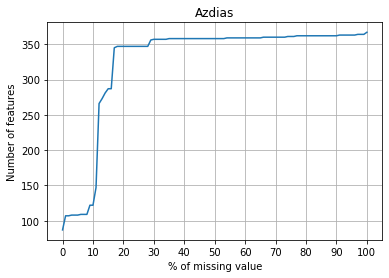

In [39]:
plt.plot(azdias_x, azdias_y)
plt.xlabel('% of missing value')
plt.xticks(np.arange(0, 110, step=10))
plt.ylabel('Number of features')
plt.title('Azdias')
plt.grid(b=True)
plt.show()

In [33]:
customers_x=[]
customers_y=[]
for cap in range(101):
    customers_x.append(cap)
    customers_y.append(len(feature_cap(customers_missing, cap)))

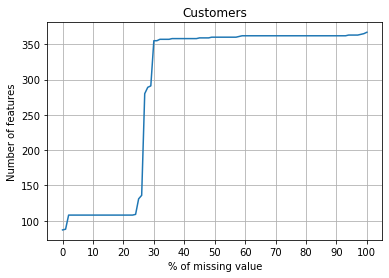

In [38]:
plt.plot(customers_x, customers_y)
plt.xlabel('% of missing value')
plt.xticks(np.arange(0, 110, step=10))
plt.ylabel('Number of features')
plt.title('Customers')
plt.grid(b=True)
plt.show()

### From theese plot we can see that we could take a cap of around 18% for azdias dataset, but most of customers datasets columns have more than that. 30% seems to be a good choice overall

In [29]:
azdias_features_selected = feature_cap(azdias_missing, 30)
print(len(azdias_features_selected))

357


In [30]:
customers_features_selected = feature_cap(customers_missing, 30)
print(len(customers_features_selected))

355


### We can see that with the same cap we dont have the same amount of features selected between azdias and customers dataframe.

### Therefore we will need to check for the features that are selected in both.

In [31]:
list(set(azdias_features_selected) - set(customers_features_selected))

['REGIOTYP', 'KKK']

In [32]:
list(set(customers_features_selected) - set(azdias_features_selected))

[]

In [33]:
#since there is only 2 features selected more in azdias than customers and none the other way around,
#we just keep customers_features_selected as features_selected for both in the future 

features_selected = customers_features_selected

In [34]:
#getting rid of the features we dont need
azdias = azdias[features_selected]

### We now need to do some feature engineering around the categorical data

In [9]:
def features_engineering(df):
    '''
    This function takes a demographic dataframe to create new features
    and encode select categorical features
    Args: 
        df (df) : demographic dataframe
    returns: 
        df (df) : dataframe with new features
    '''
    # Dealing with Unnamed 0
    if 'Unnamed: 0' in df:
        df.drop(['Unnamed: 0'], axis = 1, inplace = True)
        
    # Dealing with ANREDE_KZ
    if 'ANREDE_KZ' in df:
        df = pd.get_dummies(df, columns = ['ANREDE_KZ'], prefix = ['ANREDE_KZ'], dummy_na = True, drop_first = True)
    
    # Dealing with CAMEO_DEU_2015
    if 'CAMEO_DEU_2015' in df:
        most_frequent = df['CAMEO_DEU_2015'].value_counts().idxmax()
        df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(['XX'], most_frequent).fillna(most_frequent)
        values = np.array(df['CAMEO_DEU_2015'])
        encoder = LabelEncoder()
        encoded = encoder.fit_transform(values)
        df['CAMEO_DEU_2015'] = encoded
    
    #dealing with CAMEO_INTL_2015
    if 'CAMEO_INTL_2015' in df:
        most_frequent = df['CAMEO_INTL_2015'].value_counts().idxmax()
        df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].fillna(most_frequent)
        df['FAMILY_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: float(str(x)[1]))
        df['FAMILY_REVENUE'] = df['CAMEO_INTL_2015'].apply(lambda x: float(str(x)[0]))
        df.drop(['CAMEO_INTL_2015'], axis = 1, inplace = True)
    
    # Dealing with EINGEFUEGT_AM
    if 'EINGEFUEGT_AM' in df:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    
    #dealing with D19_LETZTER_KAUF_BRANCHE
    if 'D19_LETZTER_KAUF_BRANCHE' in df:
        df.drop(['D19_LETZTER_KAUF_BRANCHE'], axis = 1, inplace = True)
    #dealing with LP_LEBENSPHASE_FEIN
    if 'LP_LEBENSPHASE_FEIN' in df:
        replace_dict = {1: 1,
                        2: 1,
                        3: 2,
                        4: 2,
                        5: 1,
                        6: 1,
                        7: 2,
                        8: 2,
                        9: 2,
                        10: 3,
                        11: 2,
                        12: 2,
                        13: 4,
                        14: 2,
                        15: 1,
                        16: 2,
                        17: 2,
                        18: 3,
                        19: 3,
                        20: 4,
                        21: 1,
                        22: 2,
                        23: 3,
                        24: 1,
                        25: 2,
                        26: 2,
                        27: 2,
                        28: 4,
                        29: 1,
                        30: 2,
                        31: 1,
                        32: 2,
                        33: 2,
                        34: 2,
                        35: 4, 
                        36: 2,
                        37: 2,
                        38: 2,
                        39: 4,
                        40: 4}
        
        df['LP_LEBENSPHASE_FEIN_WEALTH'] = df['LP_LEBENSPHASE_FEIN'].map(replace_dict)
        
        replace_dict = {1: 1,
                        2: 2,
                        3: 1,
                        4: 2,
                        5: 3,
                        6: 4,
                        7: 3,
                        8: 4,
                        9: 2,
                        10: 2,
                        11: 3,
                        12: 4,
                        13: 3,
                        14: 1,
                        15: 3,
                        16: 3,
                        17: 2,
                        18: 1,
                        19: 3,
                        20: 3,
                        21: 2,
                        22: 2,
                        23: 2,
                        24: 2,
                        25: 2,
                        26: 2,
                        27: 2,
                        28: 2,
                        29: 1,
                        30: 1,
                        31: 3,
                        32: 3,
                        33: 1,
                        34: 1,
                        35: 1, 
                        36: 3,
                        37: 3,
                        38: 4,
                        39: 2,
                        40: 4}
        
        df['LP_LEBENSPHASE_FEIN_AGE'] = df['LP_LEBENSPHASE_FEIN'].map(replace_dict)
        df.drop(['LP_LEBENSPHASE_FEIN'], axis = 1, inplace = True)
        
    # Dealing with OST_WEST_KZ 
    if 'OST_WEST_KZ' in df:
        replace_dict = {'W':0,
                        'O':1}
        
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(replace_dict)
        
    # Dealing with PRAEGENDE_JUGENDJAHRE
    if 'PRAEGENDE_JUGENDJAHRE' in df:
        replace_dict = {2: 1,
                        3: 2,
                        4: 2,
                        5: 3,
                        6: 3,
                        7: 3,
                        8: 4,
                        9: 4,
                        10: 5,
                        11: 5,
                        12: 5,
                        13: 5,
                        14: 6,
                        15: 6}
        
        df['PRAEGENDE_JUGENDJAHRE_NEW'] = df['PRAEGENDE_JUGENDJAHRE'].map(replace_dict)
        df.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)
    
    #Dealing with WOHNLAGE
    if 'WOHNLAGE' in df:
        replace_dict = {0.0:3,
                        1.0:1,
                        2.0:2,
                        3.0:3,
                        4.0:4,
                        5.0:5,
                        7.0:3,
                        8.0:3}
        
        df['WOHNLAGE_QUALITAT'] = df['WOHNLAGE'].map(replace_dict)
        
        replace_dict = {1.0:0,
                        2.0:0, 
                        3.0:0, 
                        4.0:0, 
                        5.0:0, 
                        7.0:1, 
                        8.0:1}
        
        df['WOHNLAGE_RURAL'] = df['WOHNLAGE'].map(replace_dict)
        df.drop(['WOHNLAGE'], axis = 1, inplace = True)
    
    print('Replacing the NaNs value in the dataframe with the most frequent one')
    for feat in df:
        most_frequent = df[feat].value_counts().idxmax()
        df[feat] = df[feat].fillna(most_frequent)
   

    return df
    

In [36]:
azdias = features_engineering(azdias)

Replacing the NaNs value in the dataframe with the most frequent one


In [37]:
#quick check if everything has gone as intended

missing_pct(azdias)['percent_missing'].sum()

0.0

In [38]:
customers = features_engineering(customers)

Replacing the NaNs value in the dataframe with the most frequent one


In [39]:
missing_pct(customers)['percent_missing'].sum()

0.0

In [40]:
#check if there is any categorical feature that would need engineering

selected_categorical = []
for cat in categorical:
    if cat in azdias:
        selected_categorical.append(cat)
for i in selected_categorical:
    print(i, azdias[i].unique())

CAMEO_DEU_2015 [25 35 15  5 37 13  8  0  4 42 20 36 30 21 43 40  1 12 17 14 11 18 31 39
 27 28  7 32 41 33 22  3 38 26 24 19 16  9  6 34 10 29 23  2]
CAMEO_DEUG_2015 [8. 4. 2. 6. 1. 9. 5. 7. 3.]
CJT_GESAMTTYP [2. 5. 3. 4. 1. 6.]
D19_BANKEN_DATUM [10  5  8  6  9  1  7  4  2  3]
D19_BANKEN_OFFLINE_DATUM [10  9  8  2  5  4  1  6  7  3]
D19_BANKEN_ONLINE_DATUM [10  5  8  6  9  1  4  7  2  3]
D19_GESAMT_DATUM [10  1  3  5  9  4  7  6  8  2]
D19_GESAMT_OFFLINE_DATUM [10  6  8  9  5  2  4  1  7  3]
D19_GESAMT_ONLINE_DATUM [10  1  3  5  9  4  7  6  8  2]
D19_KONSUMTYP [9. 1. 4. 3. 6. 5. 2.]
D19_TELKO_DATUM [10  6  9  8  7  5  4  2  1  3]
D19_TELKO_OFFLINE_DATUM [10  8  9  5  6  7  4  2  3  1]
D19_TELKO_ONLINE_DATUM [10  9  7  8  6  5  4  1  2  3]
D19_VERSAND_DATUM [10  1  5  9  4  8  7  6  3  2]
D19_VERSAND_OFFLINE_DATUM [10  9  6  8  5  2  1  4  7  3]
D19_VERSAND_ONLINE_DATUM [10  1  5  9  4  8  7  6  3  2]
D19_VERSI_DATUM [10  2  8  9  6  7  5  1  4  3]
D19_VERSI_OFFLINE_DATUM [10  7  9  6  

### We now have a clean dataset to work with, but the range of value can be significantly different from on column to an other, so we will need to perform some feature scaling first

In [10]:
def scaler_tool(df):
    '''
    This function takes a dataframe of numbers 
    and transform it through MinMaxScaler.
    Args: 
        df (df) : a dataframe
    returns: 
        res_df (df) : dataframe with scaled values
    '''
    features_list = df.columns
    scaler = MinMaxScaler()
    scaler.fit(df)
    res_df = pd.DataFrame(scaler.transform(df))
    res_df.columns = features_list
    
    return res_df
    

In [42]:
azdias = scaler_tool(azdias)

In [43]:
customers = scaler_tool(customers)

### We will now check our options with dimensionality reduction

In [11]:
def pca_model(df, n_components):
    '''
    This function defines a model that takes in a previously scaled dataframe and returns the result of 
    the transformation. The output is an object created post data fitting
    Args: 
        df (df) : a dataframe
        n_components (int) : number of components of the dataframe 
    returns: 
        model_pca (object) : a pca object fit with the df
    '''
    pca = PCA(n_components)
    model_pca = pca.fit(df)
    
    return model_pca

In [12]:
#explained_variance for PCA
def explained_variance_plots(scaler, title):
    '''
    Function that plots the explained variance sum for each number of
    component of the PCA
    Args: 
        scaler (object) : a scaler object
        title (str) : name of the dataset we will show in the plot's title 
    returns: 
        None
    '''
    
    plt.plot(np.cumsum(scaler.explained_variance_ratio_))
    plt.title(title)
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(b=True)

    plot = plt.show()

In [46]:
n_components_azdias = len(azdias.columns)
azdias_pca = pca_model(azdias, n_components_azdias)

In [47]:
type(azdias_pca)

sklearn.decomposition.pca.PCA

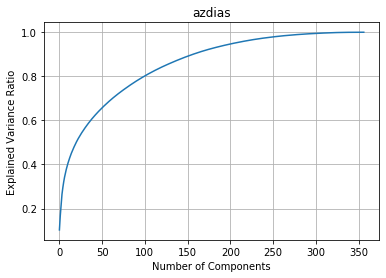

In [48]:
explained_variance_plots(azdias_pca, 'azdias')

### We will now choose 150 components for the features and then perform a Gap Statistic analysis on KMeans clustering to select the number of cluster we will use.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [49]:
pca = PCA(150)

azdias_pca = pca.fit_transform(azdias)
customers_pca = pca.fit_transform(customers)

In [100]:
def optimalK(data, nrefs=3, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        print('k :',k)
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [101]:
k, gapdf = optimalK(azdias_pca, nrefs=5, maxClusters=11)
print('Optimal k is: ', k)

k : 1
k : 2
k : 3
k : 4
k : 5
k : 6
k : 7
k : 8
k : 9
k : 10
Optimal k is:  9


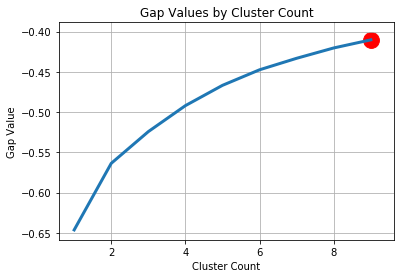

In [95]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

So the optimal number of cluster is 9

In [59]:
kmeans = KMeans(9)
model = kmeans.fit(azdias_pca)

In [61]:
cluster = pd.DataFrame()
cluster['LNR'] = azdias.index.values
cluster['cluster'] = model.labels_

In [62]:
from collections import Counter

azdias_labels = kmeans.labels_
customers_labels = kmeans.labels_
model_feat = list(azdias.columns) 
cust_feat = list(customers.columns)
model_feat_df = pd.DataFrame() 
model_feat_df['model_feat'] = model_feat

In [63]:
model_feat_notin_cust = [feat for feat in model_feat if feat not in cust_feat] 
len(model_feat_notin_cust)

customers_labels = kmeans.predict(customers_pca)

counts_customer = Counter(customers_labels) 
n_customers = customers_pca.shape[0]

customer_freqs = {label: 100*(freq / n_customers) for label, freq in counts_customer.items()}

counts_population = Counter(azdias_labels) 
n_population = azdias_pca.shape[0]

population_freqs = {label: 100*(freq / n_population) for label, freq in counts_population.items()}

customer_clusters = pd.DataFrame.from_dict(customer_freqs, orient='index', columns=['% of data']) 
customer_clusters['Cluster'] = customer_clusters.index 
customer_clusters['DataSet'] = 'Customers Data' 
population_clusters = pd.DataFrame.from_dict(population_freqs, orient='index', columns=['% of data']) 
population_clusters['Cluster'] = population_clusters.index 
population_clusters['DataSet'] = 'General Population'

all_clusters = pd.concat([customer_clusters, population_clusters]) 

,% of data,Cluster,DataSet
2,19.017803,2,Customers Data
8,3.514704,8,Customers Data
5,11.195291,5,Customers Data
1,16.049924,1,Customers Data
6,15.796339,6,Customers Data
3,3.592971,3,Customers Data
0,7.685806,0,Customers Data
4,0.301067,4,Customers Data
7,22.846096,7,Customers Data
4,8.717142,4,General Population


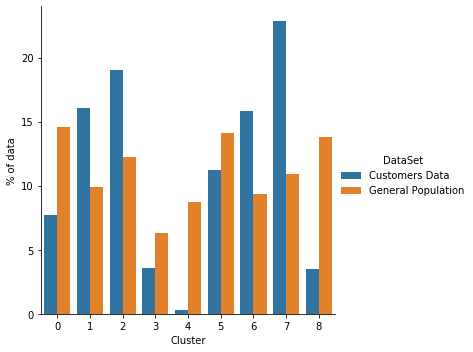

In [64]:
sns.catplot(x='Cluster', y='% of data', hue='DataSet', data=all_clusters, kind='bar')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [11]:
# load in the data

mailout_data = pd.read_csv('mailout.csv', sep=',')
mailout_test = pd.read_csv('mailout_test.csv', sep=',')

c:\users\lanth\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
#How much in % is there of response

print(len(list(mailout_data.loc[mailout_data['RESPONSE'] == 1].index))/len(mailout_data)*100,"%")

1.2383036171500394 %


### It appears that the class are very imbalanced as there is only around 1.24% of response, so the accuracy won't be a good metric to evaluate the model performances

In [13]:
#Fixing Cameo columns

mailout_data = cameo_fix(mailout_data)
mailout_test = cameo_fix(mailout_test)

In [14]:
#Replacing missing/unknowns values with nan

missing_to_nans(mailout_data, attributes_unknown)
missing_to_nans(mailout_test, attributes_unknown)

In [15]:
mailout_data_missing = missing_pct(mailout_data)

In [16]:
mailout_test_missing = missing_pct(mailout_test)

In [16]:
mailout_x=[]
mailout_y=[]
for cap in range(101):
    mailout_x.append(cap)
    mailout_y.append(len(feature_cap(mailout_data_missing, cap)))

In [17]:
mailout_test_x=[]
mailout_test_y=[]
for cap in range(101):
    mailout_test_x.append(cap)
    mailout_test_y.append(len(feature_cap(mailout_test_missing, cap)))

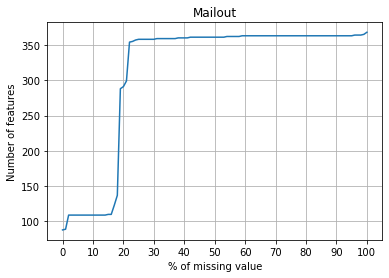

In [18]:
plt.plot(mailout_x, mailout_y)
plt.xlabel('% of missing value')
plt.xticks(np.arange(0, 110, step=10))
plt.ylabel('Number of features')
plt.title('Mailout')
plt.grid(b=True)
plt.show()

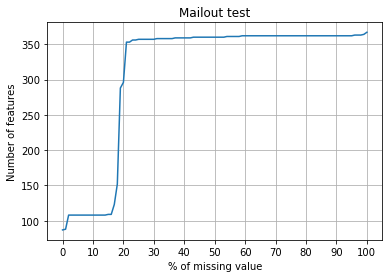

In [19]:
plt.plot(mailout_test_x, mailout_test_y)
plt.xlabel('% of missing value')
plt.xticks(np.arange(0, 110, step=10))
plt.ylabel('Number of features')
plt.title('Mailout test')
plt.grid(b=True)
plt.show()

In [17]:
#Computing the list of columns in mailout_data that have less than 30% of missing values

mailout_data_missing = missing_pct(mailout_data)
mailout_data_features_selected = feature_cap(mailout_data_missing, 30)

In [18]:
#Computing the list of columns in mailout_test that have less than 30% of missing values

mailout_test_missing = missing_pct(mailout_test)
mailout_test_features_selected = feature_cap(mailout_test_missing, 30)

In [19]:
print(len(mailout_data_features_selected))
print(len(mailout_test_features_selected))

358
357


In [20]:
list(set(mailout_data_features_selected) - set(mailout_test_features_selected))

['RESPONSE']

In [21]:
list(set(mailout_test_features_selected) - set(mailout_data_features_selected))

[]

In [22]:
mailout_data = mailout_data[mailout_data_features_selected]

In [23]:
mailout_test = mailout_test[mailout_test_features_selected]

### So we have the same columns exept for the RESPONSE that is not in the test dataset

In [25]:
mailout_data = features_engineering(mailout_data)
mailout_test = features_engineering(mailout_test)

Replacing the NaNs value in the dataframe with the most frequent one
Replacing the NaNs value in the dataframe with the most frequent one


In [26]:
mailout_train_X = mailout_data.drop(['RESPONSE'], inplace=False, axis=1)

In [28]:
mailout_train_y = mailout_data['RESPONSE']

In [29]:
mailout_train_X = mailout_train_X.drop(['LNR'], inplace=False, axis=1)

In [30]:
mailout_test_X = mailout_test.drop(['LNR'], inplace=False, axis=1)

In [31]:
mailout_train_X.shape

(42962, 358)

In [30]:
mailout_test_X.shape

(42833, 358)

In [32]:
scaler = MinMaxScaler()
scaler.fit(mailout_train_X.astype(float))

mailout_train_X_scaled = scaler.transform(mailout_train_X)
mailout_test_X_scaled = scaler.transform(mailout_test_X)

In [32]:
seed = 42

In [69]:
models = [('MLP', MLPClassifier(random_state=seed)),
          ('LR', LogisticRegression(solver='liblinear', random_state=seed)),
          ('RF', RandomForestClassifier(n_estimators=250, random_state=seed)),
          ('LGBM', lgb.LGBMClassifier(random_state=seed)),
          ('GB', GradientBoostingClassifier(random_state=seed)),
          ('XGB', xgb.XGBClassifier(random_state=seed))]

In [54]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    
    return : float, the test score mean
    """
    plt.figure()
    plt.title("Learning curve ({})".format(title))
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.yticks(np.arange(0.20, 1.1, 0.1))
    
    plt.show()
    
    return test_scores_mean[-1]

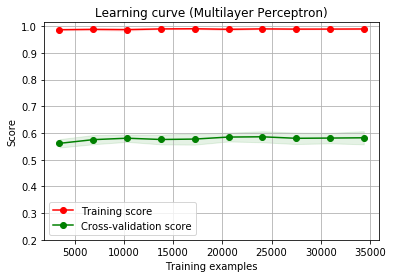

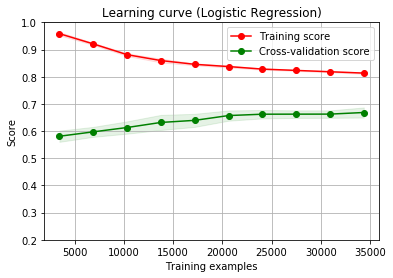

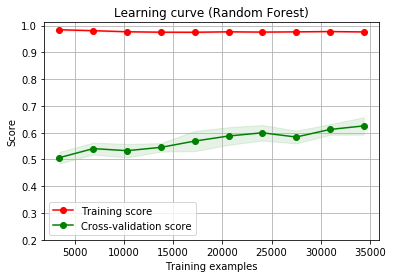

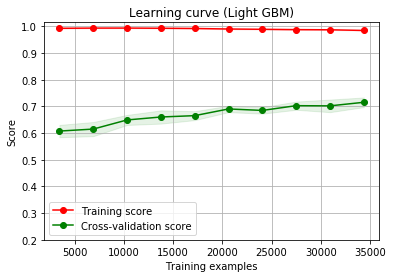

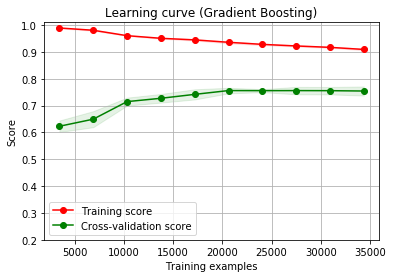

c:\users\lanth\appdata\local\programs\python\python37\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


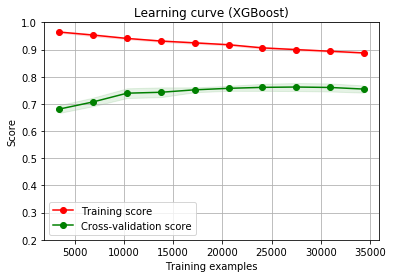

Wall time: 30min 41s


In [56]:
%%time

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

models_list = [
    [MLPClassifier(random_state=seed), "Multilayer Perceptron"],
    [LogisticRegression(solver='liblinear', random_state=seed), "Logistic Regression"],
    [RandomForestClassifier(n_estimators=200, random_state=seed), "Random Forest"],
    [lgb.LGBMClassifier(random_state=seed), "Light GBM"],
    [GradientBoostingClassifier(random_state=seed), "Gradient Boosting"],
    [xgb.XGBClassifier(random_state=seed), "XGBoost"]]

score = []
model = []
for estimator, title in models_list:

    score.append(
        round(
            plot_learning_curve(estimator, title, mailout_train_X_scaled, mailout_train_y, cv=cv, n_jobs=5),3))
    model.append(title)
    
score_pd = pd.DataFrame({'Model':model, 'Score': score})

In [51]:
score_pd

,Model,Score
0,Multilayer Perceptron,0.582
1,Logistic Regression,0.668
2,Random Forest,0.625
3,Light GBM,0.716
4,Gradient Boosting,0.754
5,XGBoost,0.755


### With the given results, we will now tune the xgboost hyperparameters using BayesSearchCV because Random search would takes to much time to achieve the same results

In [56]:
bayes_cv_tuner_xg = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = -1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        verbosity=1,
    ),
    search_spaces = {
        'booster': ['gbtree','dart'],
        'learning_rate': (0.001, 1.0, 'log-uniform'),
        'max_depth': (1, 10),
        'n_estimators': (10, 500),
        'min_child_weight': (1, 10),
        'gamma': (0.0, 1.0, 'uniform'),
        'subsample': (0.5, 1.0, 'uniform'),
        'colsample_bytree': (0.5, 1.0, 'uniform'),
        'reg_alpha': (1e-10, 1.0, 'log-uniform'),
        'scale_pos_weight': (1,100)
        
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state= seed
    ),
    n_jobs = -1,
    n_iter = 200,   
    verbose = 0,
    refit = True,
    random_state = np.random.RandomState(50)
)

In [58]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format },
    all_models = pd.DataFrame(bayes_cv_tuner_xg.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_xg.best_params_)
    
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_xg.best_score_, 4),
        bayes_cv_tuner_xg.best_params_
    ))    
    
    # Save all model results
    clf_name = bayes_cv_tuner_xg.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [42]:
%%time
result_xgb = bayes_cv_tuner_xg.fit(mailout_train_X_scaled, mailout_train_y, callback=status_print)

Model #1
Best ROC-AUC: 0.6413
Best params: OrderedDict([('booster', 'gbtree'), ('colsample_bylevel', 0.7185117255798916), ('colsample_bytree', 0.5828561281284081), ('colsample_node', 0.5603597791895552), ('gamma', 0.4382868217830673), ('learning_rate', 0.14997133845209726), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 418), ('reg_alpha', 2.9429270136817356e-06), ('scale_pos_weight', 77), ('subsample', 0.627225632603845)])

Wall time: 5min 27s


In [59]:
%%time
result_xgb = bayes_cv_tuner_xg.fit(X_sm_scaled, y_sm, callback=status_print)

Model #1
Best ROC-AUC: 0.9885
Best params: OrderedDict([('booster', 'dart'), ('colsample_bytree', 0.7256080813960445), ('gamma', 0.5005020213127345), ('learning_rate', 0.49358830548776716), ('max_depth', 1), ('min_child_weight', 5), ('n_estimators', 399), ('reg_alpha', 7.001696412022888e-07), ('scale_pos_weight', 2), ('subsample', 0.7236051016015188)])

Model #2
Best ROC-AUC: 0.9887
Best params: OrderedDict([('booster', 'dart'), ('colsample_bytree', 0.9918168281236197), ('gamma', 0.8878029074840855), ('learning_rate', 0.06275790527395109), ('max_depth', 3), ('min_child_weight', 6), ('n_estimators', 415), ('reg_alpha', 0.0339162859587761), ('scale_pos_weight', 67), ('subsample', 0.5099129795787991)])

Model #3
Best ROC-AUC: 0.9909
Best params: OrderedDict([('booster', 'gbtree'), ('colsample_bytree', 0.5313631374557678), ('gamma', 0.47827923423293395), ('learning_rate', 0.15997966580324138), ('max_depth', 8), ('min_child_weight', 7), ('n_estimators', 417), ('reg_alpha', 3.609295969053959

Model #26
Best ROC-AUC: 0.9912
Best params: OrderedDict([('booster', 'gbtree'), ('colsample_bytree', 0.5), ('gamma', 1.0), ('learning_rate', 0.0506419084082493), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 485), ('reg_alpha', 1e-10), ('scale_pos_weight', 1), ('subsample', 0.8506115893553872)])

Model #27
Best ROC-AUC: 0.9912
Best params: OrderedDict([('booster', 'gbtree'), ('colsample_bytree', 0.5), ('gamma', 1.0), ('learning_rate', 0.0506419084082493), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 485), ('reg_alpha', 1e-10), ('scale_pos_weight', 1), ('subsample', 0.8506115893553872)])

Model #28
Best ROC-AUC: 0.9912
Best params: OrderedDict([('booster', 'gbtree'), ('colsample_bytree', 0.5), ('gamma', 1.0), ('learning_rate', 0.0506419084082493), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 485), ('reg_alpha', 1e-10), ('scale_pos_weight', 1), ('subsample', 0.8506115893553872)])

Model #29
Best ROC-AUC: 0.9912
Best params: OrderedDict([('bo

KeyboardInterrupt: 

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [76]:
#Best test
bayes_xgb = xgb.XGBClassifier(booster='gbtree',
                              colsample_bytree=0.5,
                              gamma=1.0,
                              learning_rate=0.0020276515169578386,
                              max_depth=5,
                              min_child_weight=10,
                              n_estimators=251,
                              reg_alpha=1.0,
                              scale_pos_weight=34,
                              subsample=0.5,
                              eval_metric='auc',
                              verbosity=1,
                              n_jobs=-1)

In [77]:
bayes_xgb.fit(mailout_train_X_scaled, mailout_train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=1.0, learning_rate=0.0020276515169578386, max_delta_step=0,
              max_depth=5, min_child_weight=10, missing=None, n_estimators=251,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=1.0, reg_lambda=1, scale_pos_weight=34,
              seed=None, silent=None, subsample=0.5, verbosity=1)

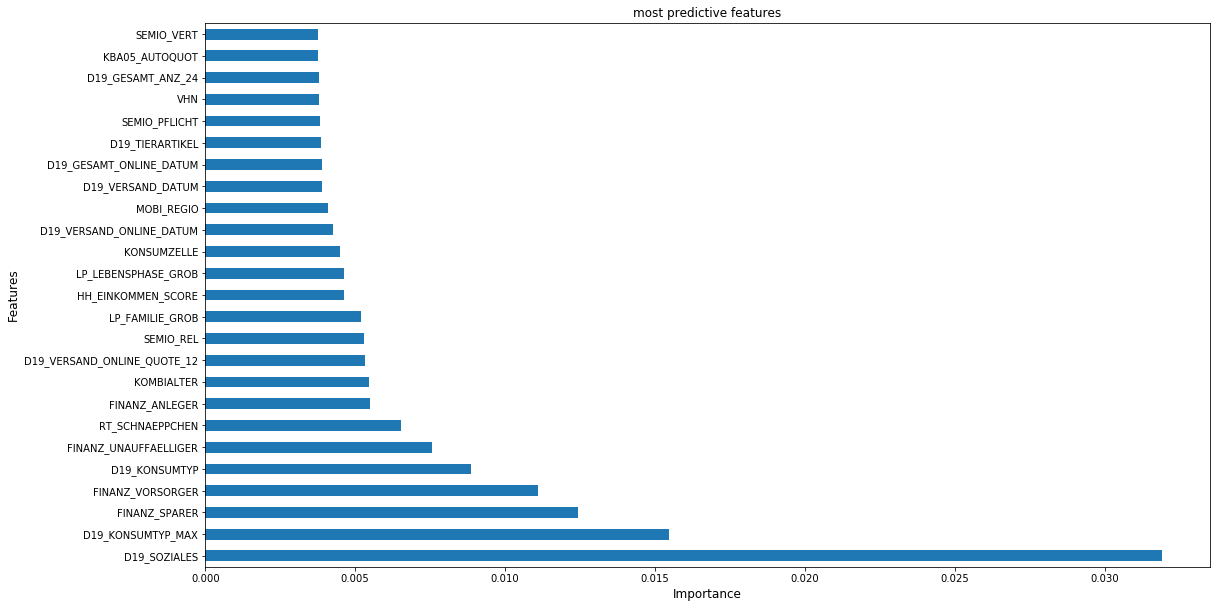

In [97]:
feat_imp = pd.Series(bayes_xgb.feature_importances_,
                     index=mailout_test_X.columns).sort_values(ascending=False)
# plot the 25 most important features
fig = plt.figure(figsize=(18, 10))
feat_imp.iloc[:25].plot(kind='barh') #, title='Feature Importances')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('most predictive features')
plt.show()

In [105]:
lnr = pd.DataFrame(mailout_test['LNR'])
pred = bayes_xgb.predict_proba(mailout_test_X_scaled)[:,1]
pred = pd.DataFrame(pred)
sub = pd.concat([lnr,pred], axis=1)

In [106]:
sub = sub.loc[~np.isnan(sub['LNR'])]

In [107]:
#change LNR column type from float to int
sub['LNR'] = sub['LNR'].astype(int)
sub = sub.rename(columns={0: "RESPONSE"})
sub.set_index('LNR', inplace = True)

In [108]:
sub.to_csv('submission.csv')